# Use skimage.restoration.wiener 

http://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.wiener

ioriginal image shape = (512, 512)
ioriginal image shape = (5, 5)


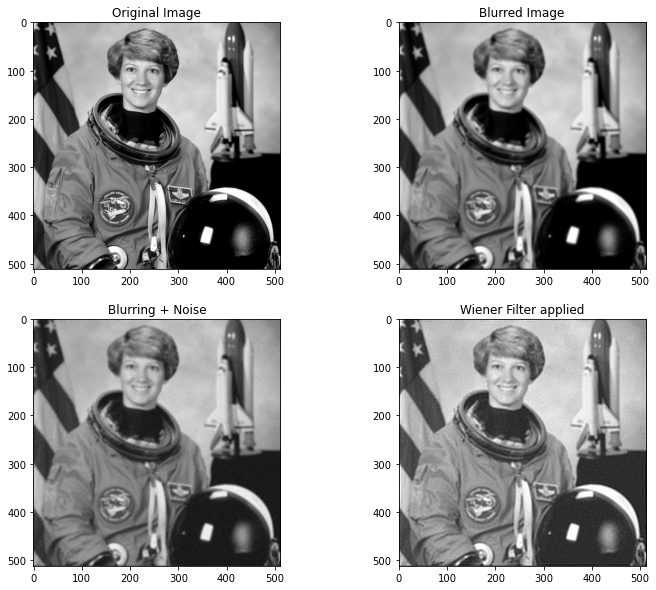

In [1]:
from skimage import color, data, restoration
import os
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean

img = color.rgb2gray(data.astronaut())

# img=resize(img, (256, 256),anti_aliasing=True)

print("ioriginal image shape =",img.shape )

psf = np.ones((5, 5)) / 25

# plt.imshow(psf)
print("ioriginal image shape =",psf.shape )

blurred_img = convolve2d(img, psf, 'same')

# plt.imshow(img)

noisy_img = blurred_img+ 0.1 * blurred_img.std() * np.random.standard_normal(blurred_img.shape)

# plt.imshow(img)

deconvolved_img = restoration.wiener(noisy_img, psf,0.1)

# plt.imshow(img)



# Display results
display = [img, blurred_img, noisy_img, deconvolved_img]
label = ['Original Image', 'Blurred Image', 'Blurring + Noise', 'Wiener Filter applied']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

# USE restoration.unsupervised_wiener as: 
    https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.unsupervised_wiener

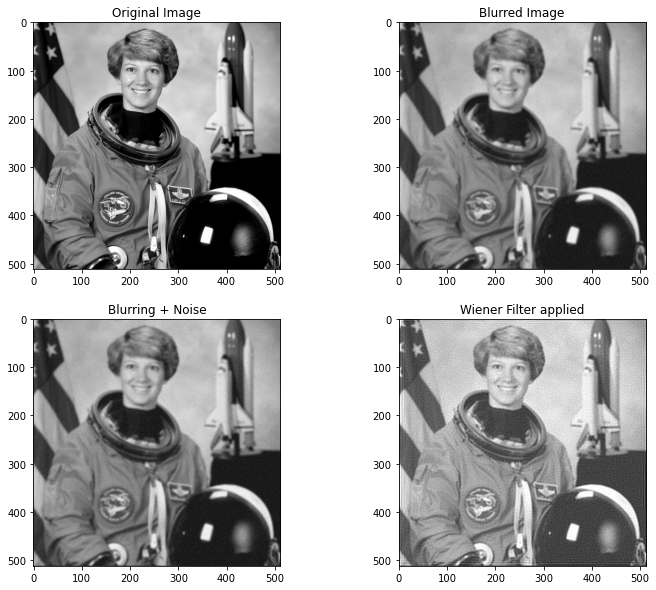

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration

rng = np.random.default_rng()

astro = color.rgb2gray(data.astronaut())

# astro=resize(astro, (256, 256),anti_aliasing=True)


psf = np.ones((5, 5)) / 25

astro = conv2(astro, psf, 'same')
blurred_img= astro

astro += 0.1 * astro.std() * rng.standard_normal(astro.shape)
noisy_img = astro

deconvolved, _ = restoration.unsupervised_wiener(astro, psf)
deconvolved_img = deconvolved


# Display results
display = [img, blurred_img, noisy_img, deconvolved_img]
label = ['Original Image', 'Blurred Image', 'Blurring + Noise', 'Wiener Filter applied']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

# Test with SWEET PSF !

In [72]:
# !pip install -r requirements.txt

In [3]:
#make costumed psf 
import pyDOE as doe 
from tqdm import tqdm
from sweet.sweet import Sweet
from sweet.util.fft import shift, fft_conv
from scipy.stats.distributions import uniform


def get_psf(S, A, C, pupil_diam):
    sweet = Sweet()
    sweet.set_eye_prescription(
        S = S,  
        A = A,
        C = C,  
    )
    sweet.set_experiment_params(
        pupil_diam = pupil_diam,  
        view_dist = 100.0,      
        canvas_size_h = 10.0,  
    )
    psf = sweet._psf()
    return psf
    
fixed_params = {
    'pupil_diam' : 2.5,
    'A' : 0
    
    # order: S[-8,-4], A, C[-3,0], pupil_diam
    # for later: needs to be : S[-8,-2], C[-3,0], A[0,360 degree]
}  
      
def costumed_psf(rand_values=True,
                 S=-4.0,
                 C=-1.5,
                 sphere_first_value=-8.0,
                 sphere_scale=4,
                 Cylinder_first_value=-3.0,
                 Cylinder_scale=3.0,
                 num_params=5):
    
    
    """
    Function to get costumed psf either by scale of Sphere and sylinder values, or by excact values for S,C.
    
    :param: rand_values: boolen to determin if psf parameters are randomly generated
    :param: S: defult=-4,sphere parameter psf, considered if rand_values=False
    :param: C: defult=0.5, Cylinder parameter psf, considered if rand_values=False
    :param: sphere_first_value: defult=-8, the first value S parameter takes
    :param: sphere_scale: defult=4, the scale that S can differ in 
    :param: Cylinder_first_value: defult=-3, the first value C parameter takes
    :param: Cylinder_scale: defult=3, the scale that C can differ in 
    :param: num_params: how many psf sample we want 
    
    :return: list of psf
    """
    
    np.random.seed(42)
    
    #num_params :how many psf sample we want 
    params = doe.lhs(4, samples=num_params) # order: S, A, C, pupil_diam
    
    #P: pupil diameter = 2.5
    params[:, 3] = fixed_params['pupil_diam']
    
    #A: angel by degrees
    params[:, 1] = fixed_params['A']
    
    if rand_values== True:
        
        #S: is random number in interval [-8,-4]
        params[:, 0] = uniform(loc=sphere_first_value, scale=sphere_scale).ppf(params[:,0])

        #C: is random number in interval [-3,0]
        params[:, 2] = uniform(loc=Cylinder_first_value, scale=Cylinder_scale).ppf(params[:, 2])
    else:
        #S: is exact number givin
        params[:, 0] = S

        #C: is exact number given
        params[:, 2] = C
    
    params = params.tolist()

    for i in tqdm(range(num_params)):
        
        #get an 256*256 numpy array as psf
#         print("*params[i]")
#         print(*params[i])
        psf = get_psf(*params[i])
        psf = psf / psf.sum()        # ADD NORMALIZING
        # add the recieved numpy array psf to list 
        params[i].append(psf)
    
    
    return params



params=costumed_psf(rand_values=True,
                 sphere_first_value=-5.0,
                 sphere_scale=1,
                 Cylinder_first_value=-1.0,
                 Cylinder_scale=1.0,
                 num_params=5)       
      

# i=0   
# for param in params:
#     plt.imshow(np.array(params[i][-1]))
#     i+=1
#     for p in param:
#         print(str(p))
#         print('\n')
#     print('\n')
            
            

100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


[-4.925091976230528, 0.0, -0.853601211637719, 2.5, array([[0.00213777, 0.00184393, 0.00187423, ..., 0.00176868, 0.00208048,
        0.00224548],
       [0.00193914, 0.0019669 , 0.00175634, ..., 0.00169384, 0.00211096,
        0.0017894 ],
       [0.00180473, 0.00211324, 0.00174354, ..., 0.00188264, 0.00204544,
        0.00178133],
       ...,
       [0.00164146, 0.00212251, 0.00177086, ..., 0.001951  , 0.00197423,
        0.00180032],
       [0.00217316, 0.00201006, 0.00170235, ..., 0.00172735, 0.00213056,
        0.0018422 ],
       [0.00218703, 0.00178923, 0.00190321, ..., 0.00178303, 0.00191887,
        0.00234233]])]


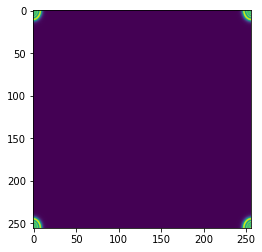

In [4]:
plt.imshow(params[0][-1])
print( params[0])

In [5]:
import torch
from NNmodels.model_rgdn import OptimizerRGDN
#path for already trained models folder:
MODEL_DIR='trainedModels/'

#load our saved model - need to be edited later
np.random.seed(42)

def load_trained_model(model: torch.nn.Module, 
                       opt: torch.optim.Optimizer,
                       name: str,
                      model_path:str) -> (torch.nn.Module, torch.optim):  
    """
    :param model: pytorch model to save
    :param opt: optimizer
    :param: model_name: name of the file where the model is stored
    :return: model with pretrained weights, optimizer
    """
    
    optimizer=opt
    path = model_path + name
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer




#initiate optimizer and a model 
rgdn = OptimizerRGDN(num_steps=5, is_rgb=False)
# optimizer = torch.optim.Optimizer()
optimizer = torch.optim.Adam(rgdn.parameters(), lr=5e-5)

#load the model
model, optimizer=load_trained_model(model=rgdn,
                                    opt=optimizer,
                                    name='RGDN-SWEET-normed-param-d-GRAY-FFT-todel-after-server-crashed-noise-added-70',
                                    model_path=MODEL_DIR
                                   )

# RGDN-SWEET-normed-param-d-GRAY-FFT-todel-after-server-crashed-noise-added-30
model.eval();






ioriginal image shape = (256, 256)
ioriginal image shape = (5, 5)


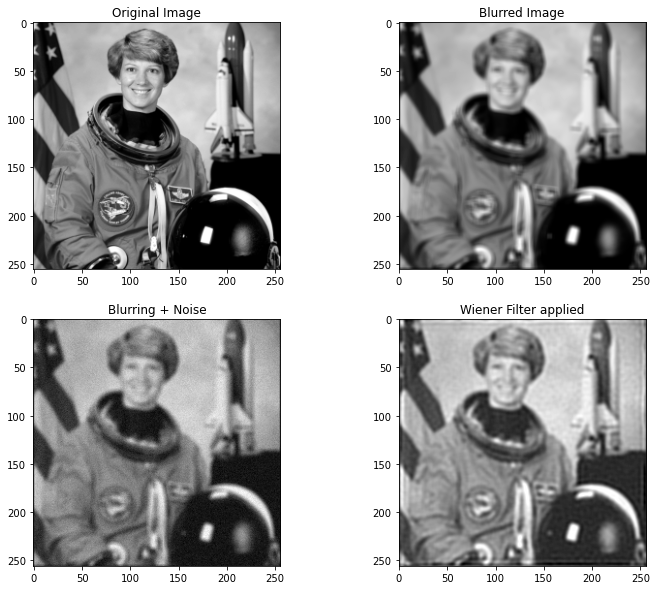

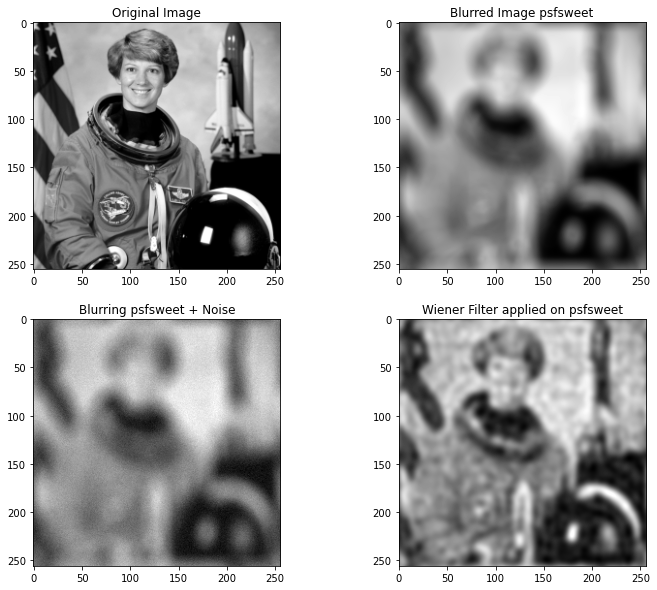

In [6]:
from skimage import color, data, restoration
import os
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean
SHIFT=True
img = color.rgb2gray(data.astronaut())

img=resize(img, (256, 256),anti_aliasing=True)

print("ioriginal image shape =",img.shape )

psf = np.ones((5, 5)) / 25
psf_sweet=params[0][-1]

# plt.imshow(psf)
print("ioriginal image shape =",psf.shape )

blurred_img = convolve2d(img, psf, 'same')

blurred_img_psfsweet = fft_conv(img, psf_sweet)


if SHIFT:
    psf_sweet = shift(psf_sweet)
    
# blurred_img_psfsweet = convolve2d(img, psf_sweet, 'same')

# plt.imshow(img)

noisy_img = blurred_img+ 0.1 * blurred_img.std() * np.random.standard_normal(blurred_img.shape)

noisy_img_psfsweet = blurred_img_psfsweet+ 0.1 * blurred_img_psfsweet.std() * np.random.standard_normal(blurred_img_psfsweet.shape)

# plt.imshow(img)

deconvolved_img = restoration.wiener(noisy_img, psf,0.1)

deconvolved_img_psfsweet = restoration.wiener(noisy_img_psfsweet, psf_sweet,0.1)

# plt.imshow(img)




# Display results
display = [img, blurred_img, noisy_img, deconvolved_img]
label = ['Original Image', 'Blurred Image', 'Blurring + Noise', 'Wiener Filter applied']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()


# Display results sweet
display = [img, blurred_img_psfsweet, noisy_img_psfsweet, deconvolved_img_psfsweet]
label = ['Original Image', 'Blurred Image psfsweet', 'Blurring psfsweet + Noise', 'Wiener Filter applied on psfsweet']


fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()



# # turn to tensors:
# y = torch.tensor(noisy_img_psfsweet, dtype=torch.float32).unsqueeze(0)
# x_gt = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
# k = torch.tensor(params[0][-1], dtype=torch.float32).unsqueeze(0)
# kt = torch.flip(k, [1, 2])

# with torch.no_grad():
#     res = model(y, k, kt)


(256, 256)
start
start


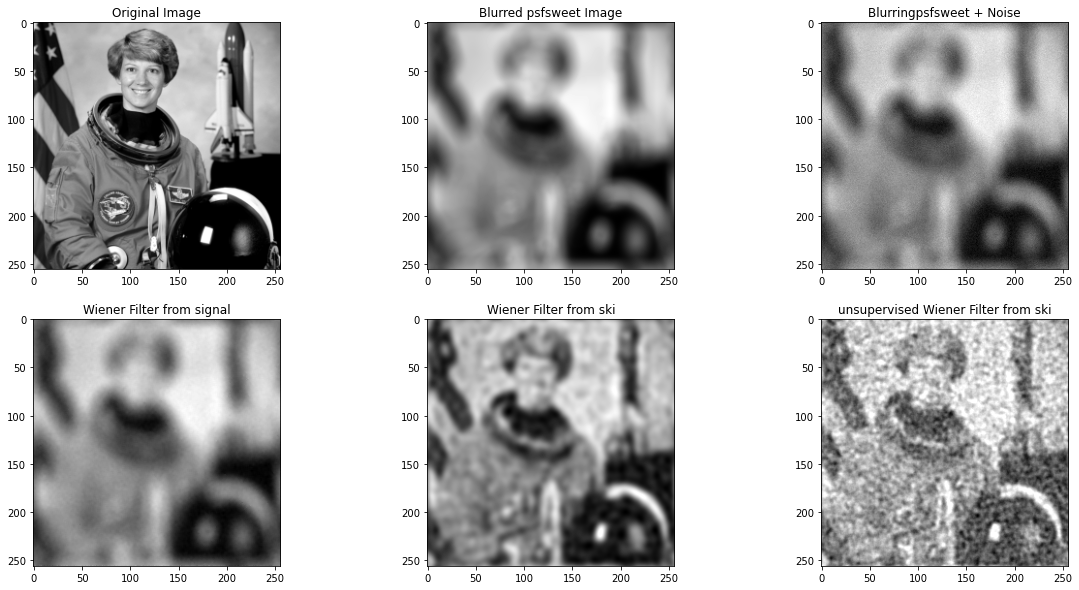

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from scipy.signal import wiener

np.random.seed(42)

rng = np.random.default_rng()

astro = color.rgb2gray(data.astronaut())
img = color.rgb2gray(data.astronaut())

astro=resize(astro, (256, 256),anti_aliasing=True)
img=resize(img, (256, 256),anti_aliasing=True)

psf = np.ones((5, 5)) / 25

psf_sweet=params[0][-1]

blurred_img = conv2(astro, psf, 'same')
blurred_img_psfsweet = fft_conv(img, psf_sweet)


if SHIFT:
    psf_sweet = shift(psf_sweet)
    
# blurred_img_psfsweet = conv2(img, psf_sweet, 'same')
print(blurred_img.shape)

noisy_img = blurred_img+ 0.1 * blurred_img.std() * rng.standard_normal(blurred_img.shape)


noisy_img_psfsweet = blurred_img_psfsweet +0.1 * blurred_img_psfsweet.std() * rng.standard_normal(blurred_img_psfsweet.shape)
# noisy_img_psfsweet = blurred_img_psfsweet


deconvolved_signal_wiener = wiener (noisy_img,(5,5) )

deconvolved_ski_wiener = restoration.wiener(noisy_img, psf,0.001)

deconvolved_ski_unsupervised_wiener, _ = restoration.unsupervised_wiener(noisy_img, psf)




deconvolved_psfsweet_signal_wiener = wiener (noisy_img_psfsweet,(3,3) )

deconvolved_psf_sweet_ski_wiener = restoration.wiener(noisy_img_psfsweet, psf_sweet,0.1)

deconvolved_psfsweet_ski_unsupervised_wiener,_ = restoration.unsupervised_wiener(noisy_img_psfsweet, psf_sweet)



# # Display results
# display = [img, blurred_img, noisy_img, deconvolved_signal_wiener, deconvolved_ski_wiener, deconvolved_ski_unsupervised_wiener]
# label = ['Original Image', 'Blurred Image', 'Blurring + Noise', 'Wiener Filter from signal','Wiener Filter from ski','unsupervised Wiener Filter from ski']

# display_sweet = [img, blurred_img_psfsweet, noisy_img_psfsweet, deconvolved_psfsweet_signal_wiener,
#                  deconvolved_psf_sweet_ski_wiener,
#                  deconvolved_psfsweet_ski_unsupervised_wiener]
# label_sweet = ['Original Image', 'Blurred psfsweet Image', 'Blurringpsfsweet + Noise', 'Wiener Filter from signal','Wiener Filter from ski','unsupervised Wiener Filter from ski']


# figsize= (20,10)
# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=figsize)
# # axs[id_img][0].imshow(kj, cmap='gray')

print("start")
for i in range(len(display)):
    if i<3:
        row=0
    else:
        row=1
    col=(i%3)
    axs[row][col].imshow(display[i], cmap='gray')
    axs[row][col].set_title(label[i])

plt.show()


figsize= (20,10)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=figsize)
# axs[id_img][0].imshow(kj, cmap='gray')

print("start")
for i in range(len(display_sweet)):
    if i<3:
        row=0
    else:
        row=1
    col=(i%3)
    axs[row][col].imshow(display_sweet[i], cmap='gray')
    axs[row][col].set_title(label_sweet[i])

plt.show()



# # Display results sweet
# display = [img, blurred_img_psfsweet, noisy_img_psfsweet, deconvolved_psfsweet]
# label = ['Original Image', 'Blurred Image psfsweet', 'Blurring psfsweet + Noise', 'Wiener Filter applied on psfsweet']

# fig = plt.figure(figsize=(12, 10))

# for i in range(len(display)):
#     fig.add_subplot(10, 2, i+1)
#     plt.imshow(display[i], cmap = 'gray')
#     plt.title(label[i])

# plt.show()

# Wiener filter as it's implemented here: 
https://www.researchgate.net/publication/332574579_Image_Processing_Course_Project_Image_Filtering_with_Wiener_Filter_and_Median_Filter

In [2]:
import os
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
import matplotlib.pyplot as plt


In [3]:
def blur(img, kernel_size = 3):
    dummy = np.copy(img)
    h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy


In [4]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

In [5]:
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [6]:
def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


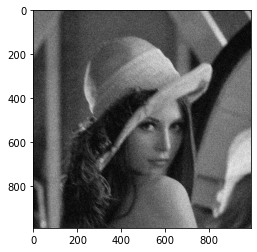

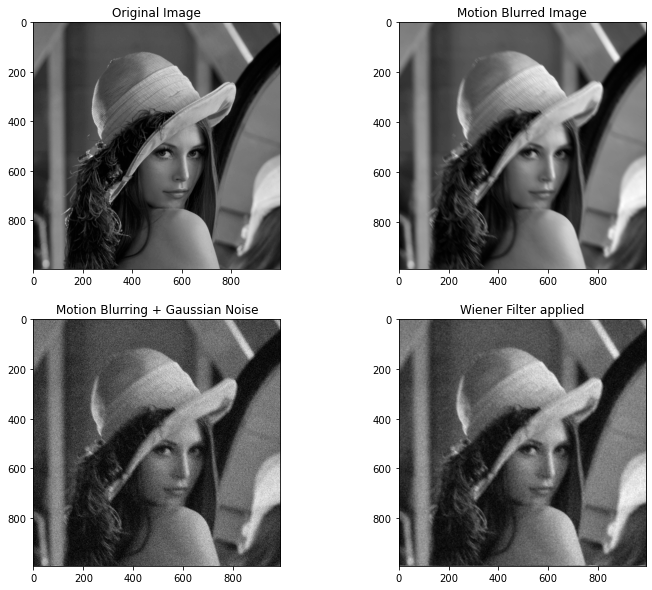

In [17]:
import scipy.misc


from scipy.signal import wiener

# Load image and convert it to gray scale
file_name = os.path.join('lena1000p.jpg') 
img = rgb2gray(plt.imread(file_name))

# Blur the image
blurred_img = blur(img, kernel_size = 10)

# Add Gaussian noise
noisy_img = add_gaussian_noise(blurred_img, sigma = 30)

# Apply Wiener Filter
kernel = gaussian_kernel(5)
filtered_img = wiener_filter(noisy_img, kernel, K = 10)

filtered_img_2= scipy.signal.wiener(noisy_img, 7, 20)

plt.imshow(filtered_img_2, cmap = 'gray')

# Display results
display = [img, blurred_img, noisy_img, filtered_img]
label = ['Original Image', 'Motion Blurred Image', 'Motion Blurring + Gaussian Noise', 'Wiener Filter applied']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()